In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/Assignment3_CNN

/content/gdrive/MyDrive/Assignment3_CNN


In [ ]:
!cp -r  /content/gdrive/MyDrive/Assignment3_CNN/Nature_dataset.zip "/content/Nature_dataset.zip"

In [ ]:
!unzip -q Nature_dataset.zip

In [ ]:
# %cd ../
!ls -la

total 354680
drwxr-xr-x 1 root root      4096 Jan  7 18:18 .
drwxr-xr-x 1 root root      4096 Jan  7 18:08 ..
drwxr-xr-x 1 root root      4096 Jan  6 18:10 .config
drwx------ 6 root root      4096 Jan  7 18:10 gdrive
-rw------- 1 root root 363152213 Jan  7 18:11 Nature_dataset.zip
drwxr-xr-x 1 root root      4096 Jan  6 18:10 sample_data
drwxr-xr-x 3 root root      4096 Jan  7 18:18 seg_pred
drwxr-xr-x 3 root root      4096 Jan  7 18:18 seg_test
drwxr-xr-x 3 root root      4096 Jan  7 18:18 seg_train


In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from random import randint

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(imgsize,imgsize)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
        
#     return Images, Labels
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [ ]:
imgsize=150
Images, Labels = get_images('/content/seg_train/seg_train/') #Extract the training images from the folders.

Images = np.array(Images, dtype=np.float32) #converting the list of images to numpy array.
Images = Images/255.0
Labels = np.array(Labels)

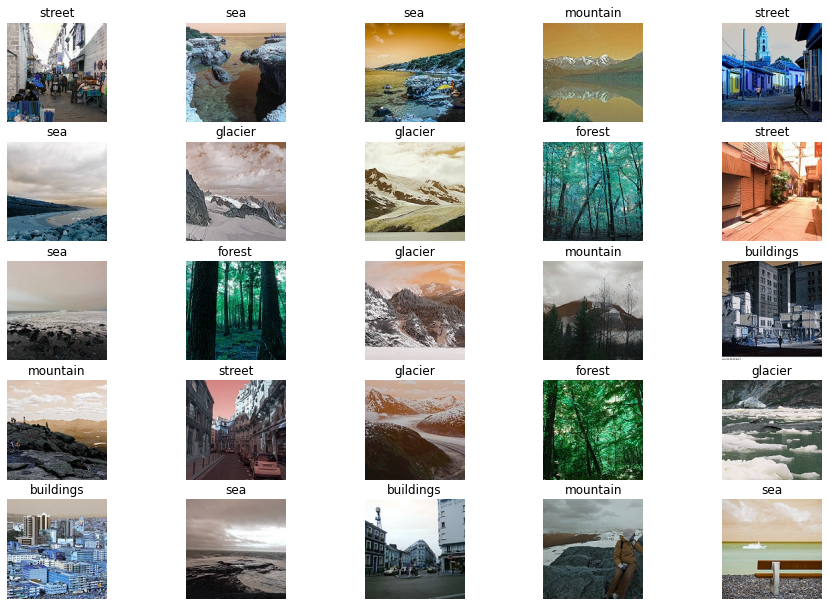

In [ ]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,2,2)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

In [ ]:
imgsize=150

train_DIR = "/content/seg_train/seg_train/"

train_datagen = ImageDataGenerator( rescale = 1.0/255,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.2,
                                          vertical_flip=True,
                                          fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(imgsize, imgsize))

test_DIR = "/content/seg_test/seg_test/"

validation_datagen = ImageDataGenerator(rescale = 1.0/255)


validation_generator = validation_datagen.flow_from_directory(test_DIR,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(imgsize, imgsize),
                                                    shuffle=False
                                                    )


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
inceptionV3 = InceptionV3(include_top= False, input_shape=(150,150,3))

for layer in inceptionV3.layers[:-4]:
	layer.trainable = False

In [ ]:
last_layer = inceptionV3.get_layer('mixed9')

print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

last layer output shape:  (None, 3, 3, 2048)


In [ ]:
inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(units = 1024, activation = tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense  (6, activation = tf.nn.softmax)(x)

inceptionV3 = tf.keras.Model( inceptionV3.input, x)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)

inceptionV3.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['acc'])

inceptionV3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
______________________________________________________________________________________________

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)

inceptionV3.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['acc'])
#inceptionV3.summary()

In [ ]:
history = inceptionV3.fit(train_generator,
                    epochs = 10,
                    verbose = 1,
                   validation_data = validation_generator,
                   callbacks=[learning_rate_reduction])

Epoch 1/10
439/439 [==============================] - 99s 201ms/step - loss: 0.7199 - acc: 0.7809 - val_loss: 0.3370 - val_acc: 0.8640
Epoch 2/10
439/439 [==============================] - 85s 193ms/step - loss: 0.3842 - acc: 0.8615 - val_loss: 0.2944 - val_acc: 0.8933
Epoch 3/10
439/439 [==============================] - 84s 192ms/step - loss: 0.3533 - acc: 0.8697 - val_loss: 0.2762 - val_acc: 0.9023
Epoch 4/10
439/439 [==============================] - 83s 189ms/step - loss: 0.3281 - acc: 0.8786 - val_loss: 0.2608 - val_acc: 0.9053
Epoch 5/10
439/439 [==============================] - 83s 189ms/step - loss: 0.3180 - acc: 0.8845 - val_loss: 0.3121 - val_acc: 0.8757

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/10
439/439 [==============================] - 83s 189ms/step - loss: 0.2755 - acc: 0.8951 - val_loss: 0.2465 - val_acc: 0.9067
Epoch 7/10
439/439 [==============================] - 83s 189ms/step - loss: 0.2456 - acc: 0.9114 - val_loss:

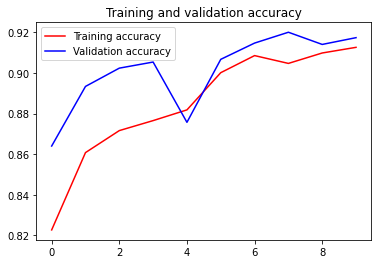

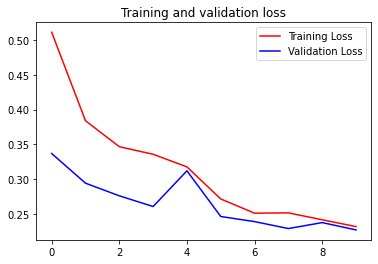

In [ ]:
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As, visually observed from above graph, the best accuracy is acheived on 9 epochs : 92%

In [ ]:
labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}

In [ ]:
validation_generator.labels

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [ ]:
y_true = validation_generator.classes
predictions = inceptionV3.predict_generator(validation_generator)
y_pred = np.array([np.argmax(xin) for xin in predictions])
cm=confusion_matrix(y_true, y_pred)
print(cm)

classes=train_generator.class_indices
report = metrics.classification_report(y_true, y_pred, target_names=classes)
print(report)    

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[408   1   0   1   3  24]
 [  0 466   3   2   2   1]
 [  1   3 466  70  12   1]
 [  1   1  50 464   8   1]
 [  2   3   5  12 488   0]
 [ 37   0   0   2   2 460]]
              precision    recall  f1-score   support

   buildings       0.91      0.93      0.92       437
      forest       0.98      0.98      0.98       474
     glacier       0.89      0.84      0.87       553
    mountain       0.84      0.88      0.86       525
         sea       0.95      0.96      0.95       510
      street       0.94      0.92      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



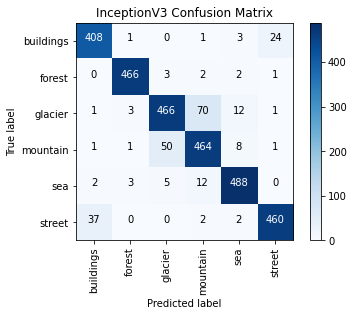

In [ ]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('InceptionV3 Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label') 
#plt.tight_layout()

import itertools
fmt = 'd'
thresh = cm.max()/2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
  


In [ ]:
inceptionV3.save('/content/gdrive/MyDrive/Assignment3_CNN/Inception_V3.h5')


Prediction portion starts from here 

In [5]:
import numpy as np
from keras.preprocessing import image
from tensorflow import keras
import os
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

inceptionV3 = keras.models.load_model('/content/gdrive/MyDrive/Assignment3_CNN/Inception_V3.h5')

In [6]:
%cd /
%cd content/
!ls -la

/
/content
total 20
drwxr-xr-x 1 root root 4096 Jan 12 16:15 .
drwxr-xr-x 1 root root 4096 Jan 12 16:12 ..
drwxr-xr-x 1 root root 4096 Jan  8 17:11 .config
drwx------ 6 root root 4096 Jan 12 16:15 gdrive
drwxr-xr-x 1 root root 4096 Jan  6 18:10 sample_data


In [7]:
!cp -r  /content/gdrive/MyDrive/Assignment3_CNN/test_Nature_dataset.zip "/content/test_Nature_dataset.zip"
!unzip -q test_Nature_dataset.zip

new way of testing prediction images

In [8]:
pred_dir =  '/content/seg_pred/seg_pred'

test_datagen = ImageDataGenerator(rescale=1. / 255)
batch=7300         #decides batch on images picked from pred

test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=batch,
    class_mode=None,
    shuffle=False       #false 
)

Found 7301 images belonging to 6 classes.


In [9]:
a=test_generator.next()
print(a.shape)

(7300, 150, 150, 3)


In [10]:
test_generator.reset()
pred=inceptionV3.predict_generator(a,verbose=1,steps=7300/730)      #7301/7301)     #/batch) #this will decide the predictions size
predicted_class_indices=np.argmax(pred,axis=1)

#labels = (train_generator.class_indices)        #names from training is right

labels={'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(len(predictions))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


10/10 [==============================] - 16s 518ms/step
7300


Following images are for comparison report

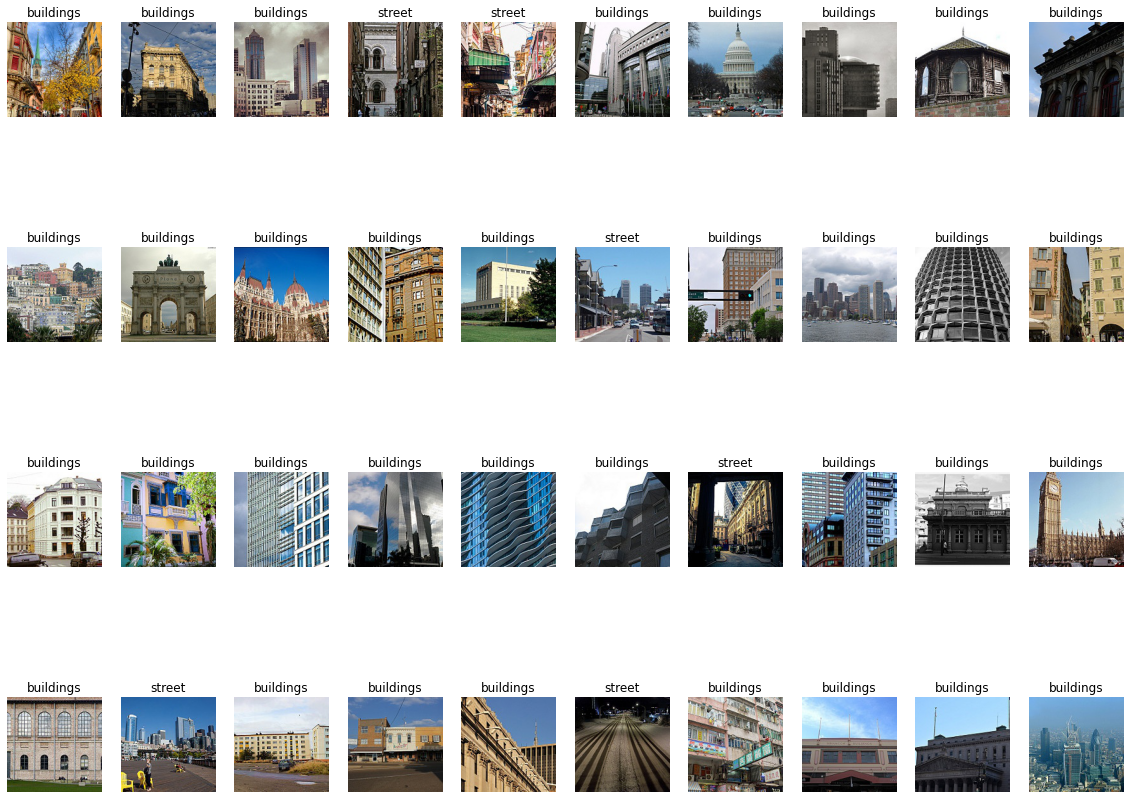

In [11]:
%matplotlib inline

k= 00             #index for picking images from pred sequence can be from 0 to 7299
# 1200
columns = 10
total=40        #total images you want to display for visualization
plt.figure(figsize=(20,20))

for i in range(0,total,1):
    plt.subplot(total / columns + 1, columns, i + 1)
    plt.imshow(a[k])
    plt.title(predictions[k])
    plt.axis('off')
    k=k+1


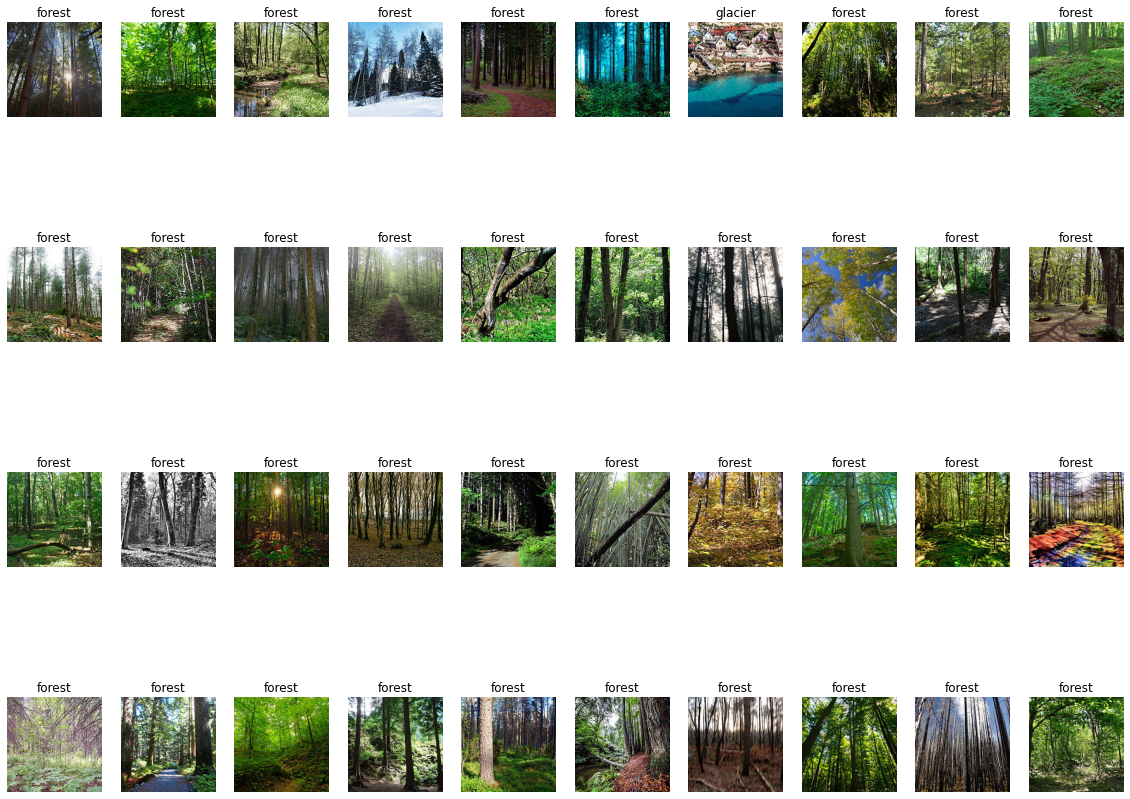

In [ ]:
%matplotlib inline

k= 1500             #index for picking images from pred sequence can be from 0 to 7299
# 1200
columns = 10
total=40        #total images you want to display for visualization
plt.figure(figsize=(20,20))

for i in range(0,total,1):
    plt.subplot(total / columns + 1, columns, i + 1)
    plt.imshow(a[k])
    plt.title(predictions[k])
    plt.axis('off')
    k=k+1


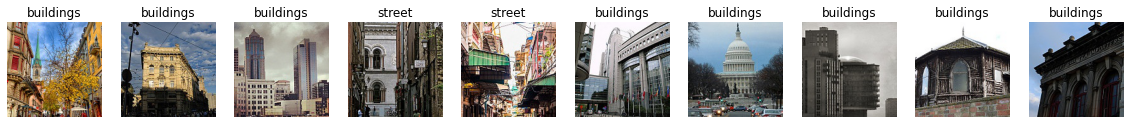

In [ ]:
%matplotlib inline

k=0              #index for picking images from pred sequence can be from 0 to 7299
columns = 10
total=10        #total images you want to display for visualization
plt.figure(figsize=(20,20))

for i in range(0,total,1):
    plt.subplot(total / columns + 1, columns, i + 1)
    plt.imshow(a[k])
    plt.title(predictions[k])
    plt.axis('off')
    k=k+1





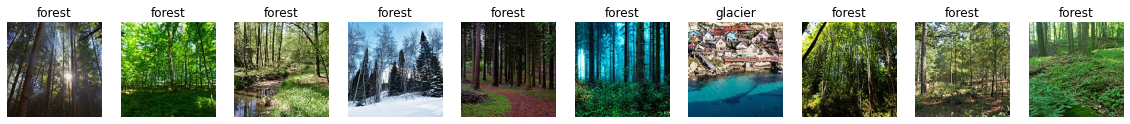

In [ ]:
%matplotlib inline

k=1500              #index for picking images from pred sequence can be from 0 to 7299
columns = 10
total=10        #total images you want to display for visualization
plt.figure(figsize=(20,20))

for i in range(0,total,1):
    plt.subplot(total / columns + 1, columns, i + 1)
    plt.imshow(a[k])
    plt.title(predictions[k])
    plt.axis('off')
    k=k+1





In [ ]:
y_true=test_generator.labels
cm=confusion_matrix(y_true[0:7300], predicted_class_indices)
cm

array([[1042,    6,    4,    2,   14,   76],
       [   5, 1144,    4,    5,    2,    6],
       [   4,    4, 1077,  188,   53,    4],
       [   3,    6,  127, 1083,   76,    2],
       [   7,    4,   32,   51, 1024,   10],
       [  78,    9,    4,    3,   11, 1130]])

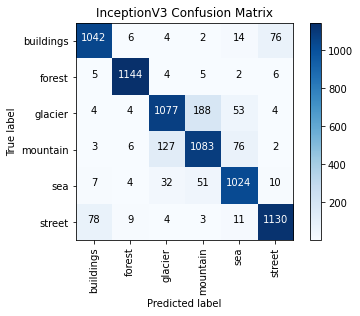

In [ ]:
labels={'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('InceptionV3 Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label') 
#plt.tight_layout()

import itertools
fmt = 'd'
thresh = cm.max()/2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

In [ ]:
import  pandas as pd
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames[0:7300],
                      "Predictions":predictions})
df=results.to_csv('/content/gdrive/MyDrive/Assignment3_CNN/InceptionV3_results.csv')

In [ ]:
results

Filename Predictions
0     buildings/10004.jpg      street
1     buildings/10048.jpg   buildings
2     buildings/10052.jpg   buildings
3     buildings/10073.jpg      street
4     buildings/10082.jpg      street
...                   ...         ...
7295      street/9950.jpg      street
7296      street/9963.jpg      street
7297      street/9972.jpg      street
7298      street/9987.jpg      street
7299      street/9988.jpg      street

[7300 rows x 2 columns]

My code ends here

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(inceptionV3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.